# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'
%matplotlib inline

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

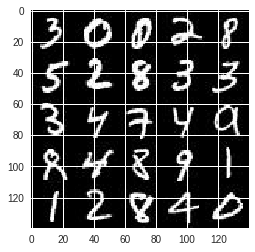

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline

import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')  
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')


### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

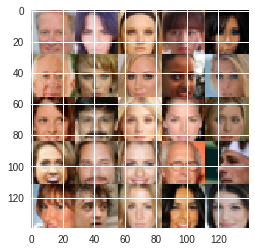

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


Discriminator
Implement discriminator to create a discriminator neural network that discriminates on images. This function should be able to reuse the variables in the neural network. Use tf.variable_scope with a scope name of "discriminator" to allow the variables to be reused. The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [59]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    keep_prob = 0.95
    kinit = tf.random_normal_initializer(stddev=0.03)
    with tf.variable_scope('discriminator', reuse=reuse):

      h1 = tf.layers.conv2d(images, 64, 7, strides=2, kernel_initializer=kinit, padding='same')
      h1 = tf.maximum(h1, h1 * alpha)
      h1 = tf.nn.dropout(h1, keep_prob=keep_prob)
      

      h2 = tf.layers.conv2d(h1, 128, 5, strides=2, padding='same')
      h2 = tf.maximum(h2, h2 * alpha)
      h2 = tf.layers.batch_normalization(h2, training = True)
      h2 = tf.nn.dropout(h2, keep_prob=keep_prob)

      h3 = tf.layers.conv2d(h2, 256, 5, strides=1, padding='same')
      h3 = tf.maximum(h3, h3 * alpha)
      h3 = tf.layers.batch_normalization(h3, training=True)
      h3 = tf.nn.dropout(h3, keep_prob=keep_prob)
     
      
      x = tf.reshape(h3, (-1, 7* 7 *256))
      logits = tf.layers.dense(x, 1)
      outputs = tf.sigmoid(logits)
    return outputs, logits 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [60]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    keep_prob = 0.95
    kinit = tf.random_normal_initializer(stddev=0.03)
    with tf.variable_scope('generator', reuse=(not is_train)):
      x = tf.layers.dense(z, 7*7*256)
      x = tf.reshape(x, (-1, 7, 7, 256))
      x = tf.maximum(x, x * alpha)
      x = tf.layers.batch_normalization(x, training=is_train)
      x = tf.nn.dropout(x, keep_prob=keep_prob)
      
      x = tf.layers.conv2d_transpose(x, 128,5, strides=1,kernel_initializer=kinit, padding='same')
      x = tf.maximum(x, x * alpha)
      x = tf.layers.batch_normalization(x, training=is_train)
      x = tf.nn.dropout(x, keep_prob=keep_prob)
      
        
      x = tf.layers.conv2d_transpose(x, 64, 7, strides=2,kernel_initializer=kinit, padding='same')
      x = tf.maximum(x, x * alpha)
      x = tf.layers.batch_normalization(x, training=is_train)
      x = tf.nn.dropout(x, keep_prob=keep_prob)
      
        
      logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=2,kernel_initializer=kinit, padding='same')
  
        
      out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [61]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    gene_out = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    disc_real_out, disc_real_logits = discriminator(input_real, alpha=alpha)
    disc_fake_out, disc_fake_logits = discriminator(gene_out, reuse=True,alpha=alpha)
    
    smooth = 0.1
    real_labels = tf.ones_like(disc_real_out) * (1-smooth)
    fake_labels = tf.zeros_like(disc_fake_out)
    gene_labels = tf.ones_like(disc_fake_out)
    
    disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_logits, labels=real_labels))
    disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, labels=gene_labels))
    
    d_loss = disc_real_loss+disc_fake_loss
    return d_loss, g_loss
    
  


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [62]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    d_vars = [var for var in variables if var.name.startswith('discriminator')]
    g_vars = [var for var in variables if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [ op for op in update_ops if op.name.startswith('discriminator')]
    g_updates = [ op for op in update_ops if op.name.startswith('generator')]
    
    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_opt, g_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_r, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_r, input_z, data_shape[3], alpha=0.1)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
               # TODO: Train Model
                
              steps += 1
              batch_images *= 2

              batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

              _ = sess.run(d_opt, feed_dict={input_r: batch_images, input_z: batch_z, lr: learning_rate})
              _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
              if steps % 10 == 0:
                  train_loss_d = d_loss.eval({input_z: batch_z, input_r: batch_images})
                  train_loss_g = g_loss.eval({input_z: batch_z})

                  print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g))

              if steps % 100 == 0:
                  show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        saver.save(sess, './generator.ckpt')
    
       
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5504... Generator Loss: 2.5738
Epoch 1/2... Discriminator Loss: 0.4215... Generator Loss: 4.3309
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 2.2939
Epoch 1/2... Discriminator Loss: 0.4196... Generator Loss: 4.9360
Epoch 1/2... Discriminator Loss: 0.4069... Generator Loss: 5.1727
Epoch 1/2... Discriminator Loss: 0.3861... Generator Loss: 4.7432
Epoch 1/2... Discriminator Loss: 0.3847... Generator Loss: 4.7458
Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 5.8774
Epoch 1/2... Discriminator Loss: 0.3812... Generator Loss: 5.3331
Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 4.6543


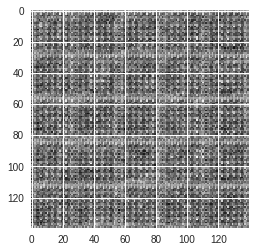

Epoch 1/2... Discriminator Loss: 0.3758... Generator Loss: 5.1351
Epoch 1/2... Discriminator Loss: 0.3701... Generator Loss: 5.3937
Epoch 1/2... Discriminator Loss: 0.6196... Generator Loss: 4.3380
Epoch 1/2... Discriminator Loss: 0.4154... Generator Loss: 5.1611
Epoch 1/2... Discriminator Loss: 0.3619... Generator Loss: 5.5854
Epoch 1/2... Discriminator Loss: 0.4870... Generator Loss: 4.9862
Epoch 1/2... Discriminator Loss: 0.4897... Generator Loss: 4.6115
Epoch 1/2... Discriminator Loss: 0.3612... Generator Loss: 5.0668
Epoch 1/2... Discriminator Loss: 0.4761... Generator Loss: 4.6745
Epoch 1/2... Discriminator Loss: 0.4320... Generator Loss: 6.7701


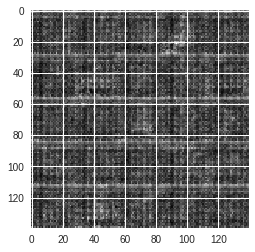

Epoch 1/2... Discriminator Loss: 0.4630... Generator Loss: 3.4739
Epoch 1/2... Discriminator Loss: 0.4015... Generator Loss: 5.5121
Epoch 1/2... Discriminator Loss: 1.9566... Generator Loss: 1.0460
Epoch 1/2... Discriminator Loss: 0.4336... Generator Loss: 4.9701
Epoch 1/2... Discriminator Loss: 0.4160... Generator Loss: 5.7537
Epoch 1/2... Discriminator Loss: 0.3591... Generator Loss: 5.6556
Epoch 1/2... Discriminator Loss: 0.4990... Generator Loss: 8.5210
Epoch 1/2... Discriminator Loss: 0.3685... Generator Loss: 4.9189
Epoch 1/2... Discriminator Loss: 0.7525... Generator Loss: 2.3482
Epoch 1/2... Discriminator Loss: 0.4068... Generator Loss: 4.1722


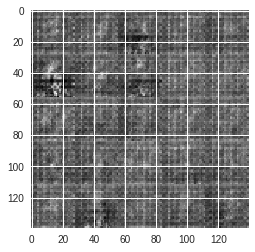

Epoch 1/2... Discriminator Loss: 0.3790... Generator Loss: 3.9824
Epoch 1/2... Discriminator Loss: 0.3659... Generator Loss: 4.6025
Epoch 1/2... Discriminator Loss: 0.3683... Generator Loss: 5.7854
Epoch 1/2... Discriminator Loss: 0.4617... Generator Loss: 4.0511
Epoch 1/2... Discriminator Loss: 0.3767... Generator Loss: 3.9190
Epoch 1/2... Discriminator Loss: 0.8078... Generator Loss: 2.8934
Epoch 1/2... Discriminator Loss: 0.4156... Generator Loss: 3.7463
Epoch 1/2... Discriminator Loss: 1.9089... Generator Loss: 0.5978
Epoch 1/2... Discriminator Loss: 0.4179... Generator Loss: 3.7619
Epoch 1/2... Discriminator Loss: 0.3755... Generator Loss: 4.2401


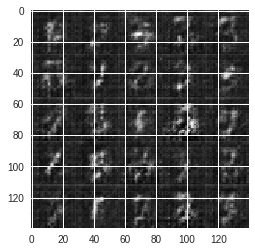

Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 4.7100
Epoch 1/2... Discriminator Loss: 0.3976... Generator Loss: 3.5848
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.3203
Epoch 1/2... Discriminator Loss: 0.4790... Generator Loss: 2.8046
Epoch 1/2... Discriminator Loss: 0.4070... Generator Loss: 3.5226
Epoch 1/2... Discriminator Loss: 0.4000... Generator Loss: 3.0381
Epoch 1/2... Discriminator Loss: 0.3943... Generator Loss: 3.5735
Epoch 1/2... Discriminator Loss: 0.6368... Generator Loss: 2.3436
Epoch 1/2... Discriminator Loss: 0.4759... Generator Loss: 2.5344
Epoch 1/2... Discriminator Loss: 0.4554... Generator Loss: 2.8510


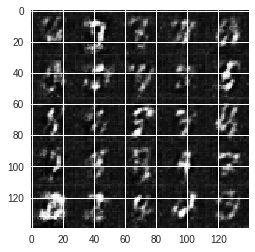

Epoch 1/2... Discriminator Loss: 0.3995... Generator Loss: 3.6225
Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 3.7010
Epoch 1/2... Discriminator Loss: 0.4947... Generator Loss: 2.9770
Epoch 1/2... Discriminator Loss: 0.4851... Generator Loss: 3.0915
Epoch 1/2... Discriminator Loss: 0.4311... Generator Loss: 2.8354
Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 1.9279
Epoch 1/2... Discriminator Loss: 0.5932... Generator Loss: 2.4490
Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 1.0352
Epoch 1/2... Discriminator Loss: 0.4921... Generator Loss: 2.7173
Epoch 1/2... Discriminator Loss: 0.5752... Generator Loss: 1.9478


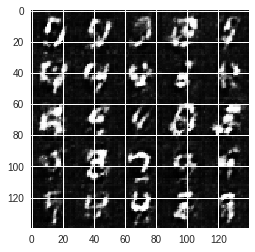

Epoch 1/2... Discriminator Loss: 0.4979... Generator Loss: 3.1903
Epoch 1/2... Discriminator Loss: 2.0236... Generator Loss: 0.4752
Epoch 1/2... Discriminator Loss: 0.6945... Generator Loss: 3.6399
Epoch 1/2... Discriminator Loss: 0.5128... Generator Loss: 2.4871
Epoch 1/2... Discriminator Loss: 0.5164... Generator Loss: 3.5634
Epoch 1/2... Discriminator Loss: 0.5761... Generator Loss: 3.4993
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 2.6641
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 3.5633
Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 3.7120
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.7160


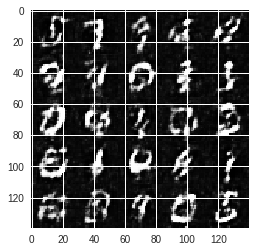

Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 2.7874
Epoch 1/2... Discriminator Loss: 0.5957... Generator Loss: 2.8891
Epoch 1/2... Discriminator Loss: 0.5625... Generator Loss: 2.0981
Epoch 1/2... Discriminator Loss: 0.5803... Generator Loss: 2.9985
Epoch 1/2... Discriminator Loss: 0.6400... Generator Loss: 3.4643
Epoch 1/2... Discriminator Loss: 0.9289... Generator Loss: 1.1639
Epoch 1/2... Discriminator Loss: 0.9196... Generator Loss: 1.1521
Epoch 1/2... Discriminator Loss: 0.5932... Generator Loss: 2.0278
Epoch 1/2... Discriminator Loss: 0.6784... Generator Loss: 1.8231
Epoch 1/2... Discriminator Loss: 0.6037... Generator Loss: 1.9790


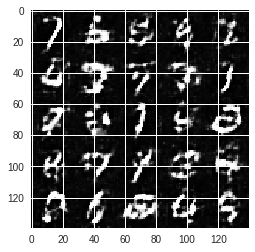

Epoch 1/2... Discriminator Loss: 1.0891... Generator Loss: 0.8852
Epoch 1/2... Discriminator Loss: 0.5651... Generator Loss: 2.0454
Epoch 1/2... Discriminator Loss: 0.6472... Generator Loss: 2.3692
Epoch 1/2... Discriminator Loss: 0.6092... Generator Loss: 2.0987
Epoch 1/2... Discriminator Loss: 0.9511... Generator Loss: 1.1979
Epoch 1/2... Discriminator Loss: 0.6534... Generator Loss: 2.9531
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 1.9419
Epoch 1/2... Discriminator Loss: 0.6676... Generator Loss: 2.5532
Epoch 1/2... Discriminator Loss: 0.6249... Generator Loss: 2.6913
Epoch 1/2... Discriminator Loss: 0.6907... Generator Loss: 2.9045


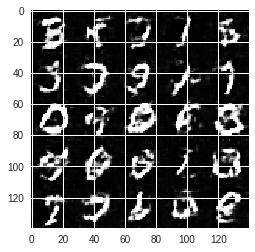

Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.5139
Epoch 1/2... Discriminator Loss: 0.5714... Generator Loss: 2.2302
Epoch 1/2... Discriminator Loss: 0.5774... Generator Loss: 2.2400
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 3.0955
Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 1.5444
Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 1.9756
Epoch 2/2... Discriminator Loss: 0.9446... Generator Loss: 1.2428
Epoch 2/2... Discriminator Loss: 0.6511... Generator Loss: 1.7074
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 1.7680
Epoch 2/2... Discriminator Loss: 0.7777... Generator Loss: 1.3398


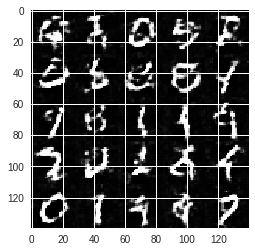

Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.6532
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 2.4582
Epoch 2/2... Discriminator Loss: 0.7251... Generator Loss: 2.8035
Epoch 2/2... Discriminator Loss: 0.7607... Generator Loss: 1.4345
Epoch 2/2... Discriminator Loss: 0.7623... Generator Loss: 3.1578
Epoch 2/2... Discriminator Loss: 0.6165... Generator Loss: 2.6422
Epoch 2/2... Discriminator Loss: 0.6065... Generator Loss: 2.4683
Epoch 2/2... Discriminator Loss: 0.6297... Generator Loss: 2.0432
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.5137
Epoch 2/2... Discriminator Loss: 0.7206... Generator Loss: 2.7259


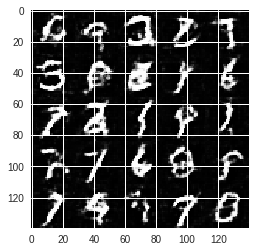

Epoch 2/2... Discriminator Loss: 0.6833... Generator Loss: 2.2251
Epoch 2/2... Discriminator Loss: 0.7051... Generator Loss: 1.4941
Epoch 2/2... Discriminator Loss: 0.6865... Generator Loss: 1.7829
Epoch 2/2... Discriminator Loss: 0.8366... Generator Loss: 1.3068
Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 2.9964
Epoch 2/2... Discriminator Loss: 0.7003... Generator Loss: 1.8225
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.8243
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 0.8552
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 2.0786
Epoch 2/2... Discriminator Loss: 0.6765... Generator Loss: 1.5720


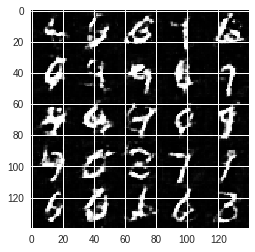

Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 1.7752
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 2.5528
Epoch 2/2... Discriminator Loss: 0.6660... Generator Loss: 1.8338
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 2.2550
Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 1.3776
Epoch 2/2... Discriminator Loss: 1.1347... Generator Loss: 3.5040
Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 1.7970
Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.7870
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 2.0421
Epoch 2/2... Discriminator Loss: 0.6665... Generator Loss: 2.3101


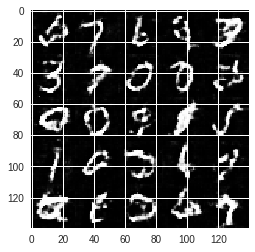

Epoch 2/2... Discriminator Loss: 0.8052... Generator Loss: 1.3042
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 3.3389
Epoch 2/2... Discriminator Loss: 0.6901... Generator Loss: 2.3429
Epoch 2/2... Discriminator Loss: 0.8384... Generator Loss: 1.6205
Epoch 2/2... Discriminator Loss: 0.7306... Generator Loss: 1.4322
Epoch 2/2... Discriminator Loss: 1.2138... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 0.7067... Generator Loss: 1.9658
Epoch 2/2... Discriminator Loss: 0.7077... Generator Loss: 1.9839
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 3.2514
Epoch 2/2... Discriminator Loss: 1.5949... Generator Loss: 0.4359


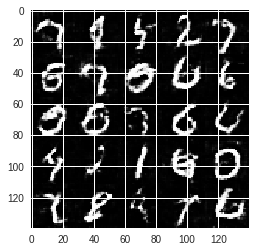

Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 1.6392
Epoch 2/2... Discriminator Loss: 0.6848... Generator Loss: 2.2443
Epoch 2/2... Discriminator Loss: 3.5170... Generator Loss: 6.0745
Epoch 2/2... Discriminator Loss: 0.7113... Generator Loss: 1.6924
Epoch 2/2... Discriminator Loss: 0.6340... Generator Loss: 2.0344
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 1.3258
Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 2.0346
Epoch 2/2... Discriminator Loss: 0.8937... Generator Loss: 1.3720
Epoch 2/2... Discriminator Loss: 1.0434... Generator Loss: 1.0509
Epoch 2/2... Discriminator Loss: 1.0114... Generator Loss: 0.9415


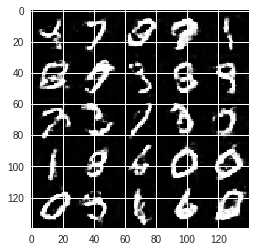

Epoch 2/2... Discriminator Loss: 0.8556... Generator Loss: 1.2240
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.7450
Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 2.0579
Epoch 2/2... Discriminator Loss: 0.8712... Generator Loss: 1.0054
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 2.7116
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.3230
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 2.1920
Epoch 2/2... Discriminator Loss: 0.8935... Generator Loss: 1.2170
Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 2.1786
Epoch 2/2... Discriminator Loss: 1.7637... Generator Loss: 0.5727


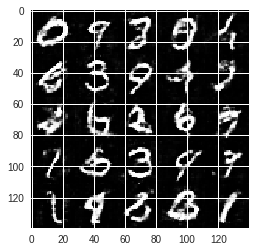

Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.5709
Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.8109
Epoch 2/2... Discriminator Loss: 0.6976... Generator Loss: 1.8036
Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 2.2268
Epoch 2/2... Discriminator Loss: 0.6777... Generator Loss: 1.7631
Epoch 2/2... Discriminator Loss: 1.4388... Generator Loss: 0.6495
Epoch 2/2... Discriminator Loss: 0.7085... Generator Loss: 2.5843
Epoch 2/2... Discriminator Loss: 0.6702... Generator Loss: 1.9055
Epoch 2/2... Discriminator Loss: 0.8471... Generator Loss: 1.6443
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.3515


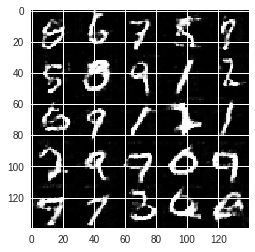

Epoch 2/2... Discriminator Loss: 0.6709... Generator Loss: 1.8761
Epoch 2/2... Discriminator Loss: 0.6569... Generator Loss: 2.3198
Epoch 2/2... Discriminator Loss: 0.9326... Generator Loss: 1.0157
Epoch 2/2... Discriminator Loss: 0.8084... Generator Loss: 1.3918
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 3.3088
Epoch 2/2... Discriminator Loss: 0.6313... Generator Loss: 2.0147
Epoch 2/2... Discriminator Loss: 0.5957... Generator Loss: 2.0282
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.0027
Epoch 2/2... Discriminator Loss: 0.6452... Generator Loss: 1.6278
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 1.2500


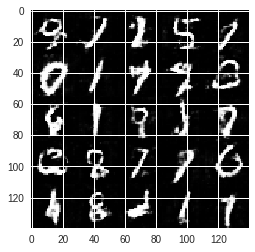

Epoch 2/2... Discriminator Loss: 0.9183... Generator Loss: 3.1341
Epoch 2/2... Discriminator Loss: 0.9864... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.2070... Generator Loss: 0.8893
Epoch 2/2... Discriminator Loss: 0.5871... Generator Loss: 2.2886
Epoch 2/2... Discriminator Loss: 0.6239... Generator Loss: 2.1140
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 1.6539
Epoch 2/2... Discriminator Loss: 0.7746... Generator Loss: 1.8389


In [65]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5

import os
from glob import glob
from matplotlib import pyplot
import helper

data_dir = './data'
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 1.8363... Generator Loss: 0.8988
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 2.8469
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 5.6566
Epoch 1/1... Discriminator Loss: 0.6097... Generator Loss: 5.8783
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 3.7512
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 2.7591
Epoch 1/1... Discriminator Loss: 1.2475... Generator Loss: 2.0746
Epoch 1/1... Discriminator Loss: 1.7119... Generator Loss: 6.7717
Epoch 1/1... Discriminator Loss: 4.5620... Generator Loss: 9.4395


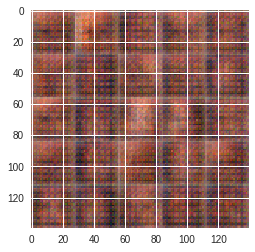

Epoch 1/1... Discriminator Loss: 2.1211... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 2.0409
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.3020
Epoch 1/1... Discriminator Loss: 1.7494... Generator Loss: 3.3608
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 1.0363
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.5105
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.5470
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 2.3210
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.0618


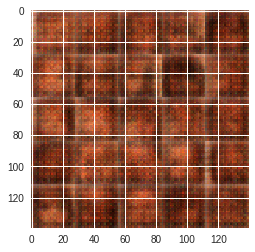

Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.9434
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 1.4793
Epoch 1/1... Discriminator Loss: 2.0000... Generator Loss: 3.0812
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.7170... Generator Loss: 2.5322
Epoch 1/1... Discriminator Loss: 1.1441... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.7610... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 1.0824
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.9201


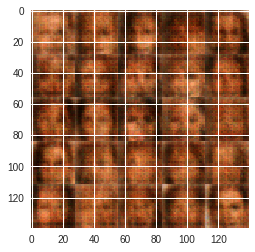

Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 1.7345
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.9462
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 1.5039
Epoch 1/1... Discriminator Loss: 1.0524... Generator Loss: 1.7650
Epoch 1/1... Discriminator Loss: 1.3506... Generator Loss: 1.3296
Epoch 1/1... Discriminator Loss: 2.2171... Generator Loss: 0.2826
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 1.5054
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 2.3194
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4395... Generator Loss: 2.3882


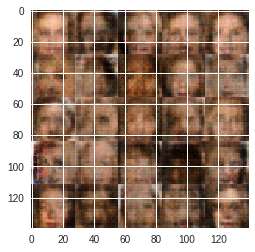

Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.2621
Epoch 1/1... Discriminator Loss: 1.2168... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 2.5603... Generator Loss: 0.2593
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.9614


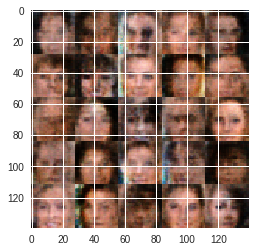

Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 1.2955
Epoch 1/1... Discriminator Loss: 2.0726... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 1.0942
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.9305


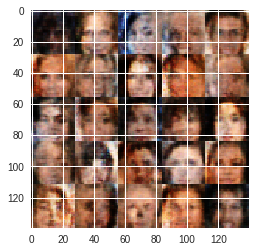

Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 1.5915
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.1744... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.2256
Epoch 1/1... Discriminator Loss: 1.0735... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.5579


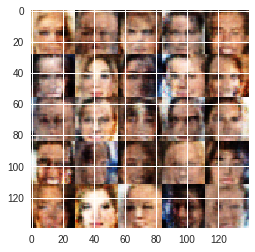

Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.1599
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 1.1257
Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.0906
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.5229
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.7565


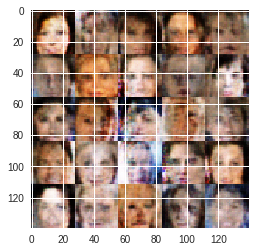

Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.3970
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 2.1199
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 1.2946
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.9322
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.1170


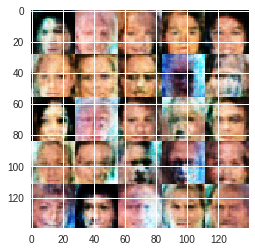

Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.0355
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.7372... Generator Loss: 0.4306
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 1.2608
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 2.3447
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.2223
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 2.0120
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.3975
Epoch 1/1... Discriminator Loss: 1.3622... Generator Loss: 0.8084


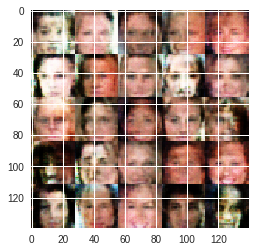

Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 1.6842
Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 1.1966
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 1.0038
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 1.4051
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 1.3984
Epoch 1/1... Discriminator Loss: 1.6110... Generator Loss: 0.4933
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.8823


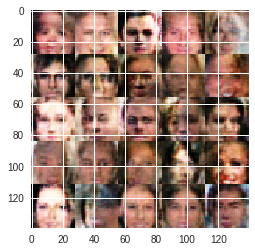

Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.9814... Generator Loss: 2.1932
Epoch 1/1... Discriminator Loss: 1.0008... Generator Loss: 1.1882
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 1.7063
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 1.1555


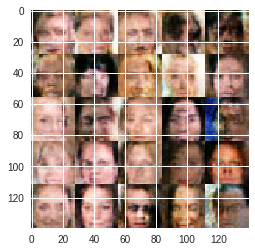

Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.8279... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.9107
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 1.9709
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.9802
Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.1238
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.6791


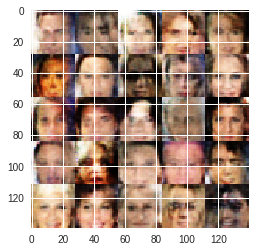

Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 1.1635
Epoch 1/1... Discriminator Loss: 1.2469... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 0.9571
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.9167
Epoch 1/1... Discriminator Loss: 0.8780... Generator Loss: 1.3705
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.1337


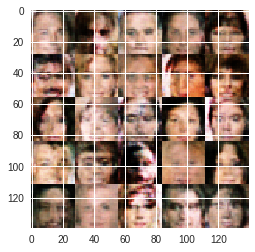

Epoch 1/1... Discriminator Loss: 1.0304... Generator Loss: 1.9166
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.0848
Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 1.1022... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 0.9532
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.1654
Epoch 1/1... Discriminator Loss: 1.8314... Generator Loss: 0.5203


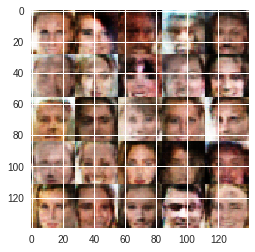

Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.2316
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.9768
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.9297... Generator Loss: 0.3539
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.7982


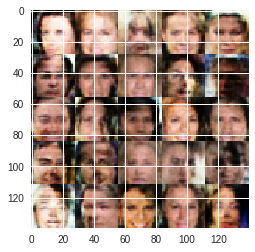

Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.7262... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 1.0089
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.7256... Generator Loss: 2.6221
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 0.9752


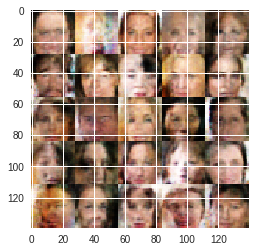

Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.1535
Epoch 1/1... Discriminator Loss: 1.5192... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.0479
Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.4856
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.2542... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 0.7729


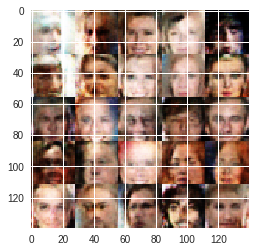

Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.9797
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.0404
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8880
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 1.1248


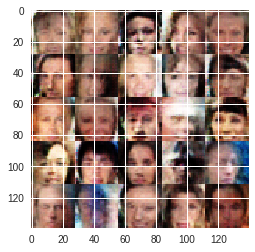

Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 1.1382
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.9897
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.2303
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.1820
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.2084
Epoch 1/1... Discriminator Loss: 1.1583... Generator Loss: 1.0102
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.5110
Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.6315


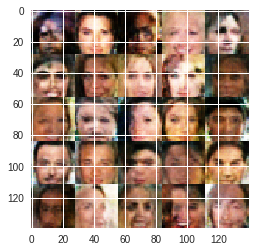

Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 2.2509... Generator Loss: 0.2693
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.9132
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 1.5337
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 1.1591... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.5920


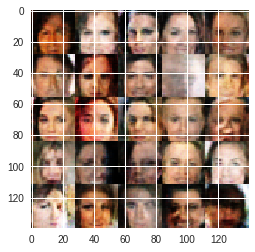

Epoch 1/1... Discriminator Loss: 1.1111... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.6138... Generator Loss: 0.5445
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.9124
Epoch 1/1... Discriminator Loss: 1.1214... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 1.1566
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.4986
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.2620... Generator Loss: 2.5026
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 1.5077


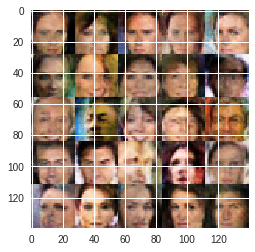

Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.2430
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 1.1612
Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.3226... Generator Loss: 1.0211
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.5025


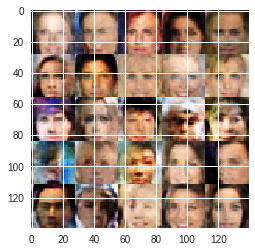

Epoch 1/1... Discriminator Loss: 1.6141... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.9913
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.1372
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.1909
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 0.9739... Generator Loss: 1.2078


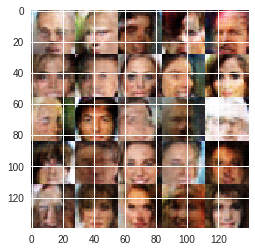

Epoch 1/1... Discriminator Loss: 0.8848... Generator Loss: 1.3329
Epoch 1/1... Discriminator Loss: 2.1452... Generator Loss: 3.5491
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 1.8695
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.9274
Epoch 1/1... Discriminator Loss: 1.0341... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 0.9535... Generator Loss: 1.5281
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.2873
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.2855


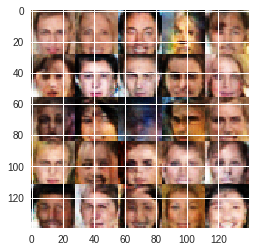

Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 2.0035
Epoch 1/1... Discriminator Loss: 1.1424... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 1.1393
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.5283... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.7310
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8998


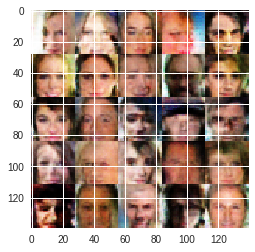

Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.5837
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.9609
Epoch 1/1... Discriminator Loss: 0.8831... Generator Loss: 1.1841
Epoch 1/1... Discriminator Loss: 1.1699... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0136
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 1.1985
Epoch 1/1... Discriminator Loss: 0.9015... Generator Loss: 1.2249


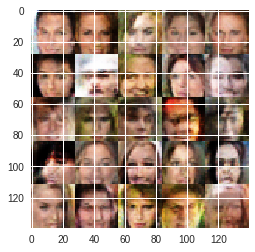

Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.2215
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.2275
Epoch 1/1... Discriminator Loss: 1.0902... Generator Loss: 1.0675
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 1.6126


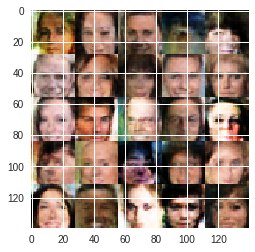

Epoch 1/1... Discriminator Loss: 1.1730... Generator Loss: 1.7156
Epoch 1/1... Discriminator Loss: 1.2945... Generator Loss: 1.6019
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.0959... Generator Loss: 0.9775
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 2.7487
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.1646
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.6782


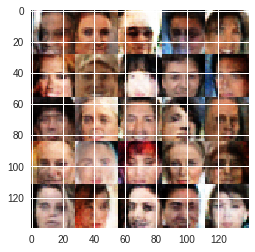

Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 1.1860
Epoch 1/1... Discriminator Loss: 1.6327... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.5615
Epoch 1/1... Discriminator Loss: 1.6675... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 1.3821
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6001


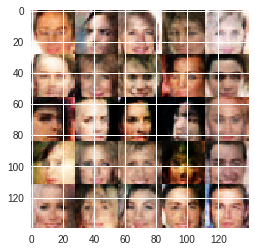

Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.3584
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.2036
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.2059
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 1.1206
Epoch 1/1... Discriminator Loss: 0.9253... Generator Loss: 1.6437
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.8061
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.3868


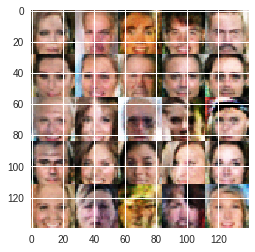

Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 1.3751
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.1261
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.0632... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.2278... Generator Loss: 0.9081


In [66]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)